In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.Tanh(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

def logprior(x):
    return prior.log_prob(x)

In [8]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [9]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [10]:
from Inference.ParallelTempering import *

In [11]:
N = 100000
temperatures = [0.5, 1, 1.5, 2, 3, 5, 10, 20, 40, 120, 500]
stateInit = [prior.sample() for i in range(len(temperatures))]
baseMHproposalNoise = 0.003
temperatureNoiseReductionFactor = 0.5

In [12]:
logtarget = lambda theta : logposterior(theta, model, x_data, y_data, 0.1 )

In [13]:
sampler = PTMCMCSampler(logtarget, param_count, baseMHproposalNoise, temperatureNoiseReductionFactor, temperatures, device)

In [15]:
import pickle
state = pickle.load( open( "MAPS.pt", "rb" ) )

In [25]:
sampler.initChains([state[i][0] for i in range(len(state))])

In [11]:
import pickle
state = pickle.load( open( "PTMCMC_checkpoint.pt", "rb" ) )

In [41]:
samples = torch.stack(state[1][100000:len(state[0]):100])

In [42]:
samples.shape

torch.Size([9001, 1, 61])

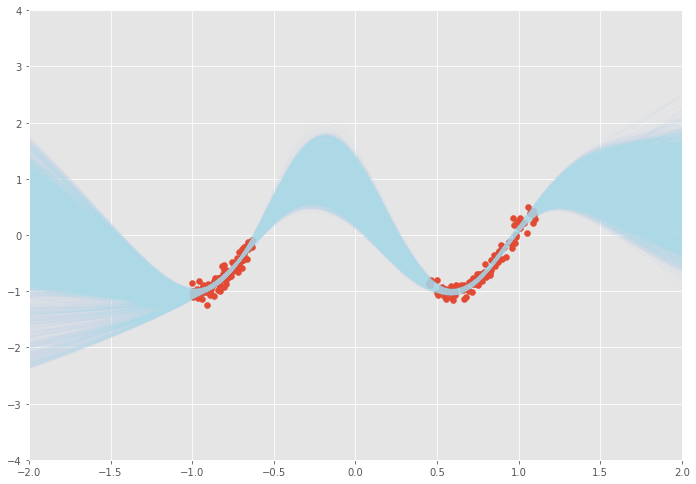

In [43]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(samples.shape[0]):
    z = samples[i,:,:]
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')